# Training the SCAN model on the cifar_10 dataset



1. Self Supervised Learning 
2. Clustering 
3. Self Labeling 



# Please move the file in the root folder. 

In [ ]:
!ls -lh

total 85K
drwx------ 2 root root 4.0K Nov 15 03:54 cifar-10
drwx------ 2 root root 4.0K Nov 11 10:51 configs
drwx------ 2 root root 4.0K Nov 11 10:51 data
drwx------ 2 root root 4.0K Nov 18 07:19 euroSAT
-rw------- 1 root root 5.6K Nov 14 08:56 eval.py
drwx------ 2 root root 4.0K Nov 11 10:51 images
-rw------- 1 root root  13K Nov 14 08:59 img.jpg
drwx------ 2 root root 4.0K Nov 11 10:51 logs
drwx------ 2 root root 4.0K Nov 11 10:51 losses
-rw------- 1 root root 4.5K Nov 11 10:51 moco.py
drwx------ 2 root root 4.0K Nov 11 10:51 models
-rw------- 1 root root 3.3K Nov 11 10:51 requirements.txt
-rw------- 1 root root 5.7K Nov 15 13:50 scan.py
-rw------- 1 root root 4.6K Nov 12 06:30 selflabel.py
-rw------- 1 root root 6.1K Nov 12 17:52 simclr.py
-rw------- 1 root root 3.9K Nov 11 10:51 tutorial_nn.py
drwx------ 2 root root 4.0K Nov 11 10:51 utils


In [ ]:
!pip install faiss                       # For efficient nearest neighbors search 
!pip install pyyaml easydict                 # For using config files
!pip install termcolor                       # For colored print statements

     |████████████████████████████████| 4.7MB 8.7MB/s 


In [ ]:
!python simclr.py --config_env configs/env.yml --config_exp configs/pretext/simclr_cifar10.yml 

{'setup': 'simclr', 'backbone': 'resnet18', 'model_kwargs': {'head': 'mlp', 'features_dim': 128}, 'train_db_name': 'cifar-10', 'val_db_name': 'cifar-10', 'num_classes': 10, 'criterion': 'simclr', 'criterion_kwargs': {'temperature': 0.1}, 'epochs': 200, 'optimizer': 'sgd', 'optimizer_kwargs': {'nesterov': False, 'weight_decay': 0.0001, 'momentum': 0.9, 'lr': 0.4}, 'scheduler': 'cosine', 'scheduler_kwargs': {'lr_decay_rate': 0.1}, 'batch_size': 512, 'num_workers': 8, 'augmentation_strategy': 'simclr', 'augmentation_kwargs': {'random_resized_crop': {'size': 32, 'scale': [0.2, 1.0]}, 'color_jitter_random_apply': {'p': 0.8}, 'color_jitter': {'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.4, 'hue': 0.1}, 'random_grayscale': {'p': 0.2}, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}, 'transformation_kwargs': {'crop_size': 32, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}, 'pretext_dir': './cifar-10/pretext', 'pretext_ch

# Pretext + Kmeans

In this method we will only be using the pretext part of the scan model. It is shown in the paper that even this method can produce results.


In [ ]:
#evaluating the models performance  
import argparse
import os
import torch
import numpy as np



pretrain_path = "cifar-10/pretext/checkpoint.pth.tar"

state_dict = torch.load(pretrain_path,map_location=torch.device('cpu'))


from models.models import ContrastiveModel
from models.resnet_cifar import resnet18
backbone = resnet18()
model = ContrastiveModel(backbone,head='mlp',features_dim=128)
        # model = ContrastiveModel(backbone, **p['model_kwargs'])
model.load_state_dict(state_dict['model'])
model.eval()

ContrastiveModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [ ]:
#getting the config
from utils.common_config import get_train_transformations,get_train_dataset,get_train_dataloader,get_val_transformations
from utils.config import create_config
from torchvision.transforms import Compose,ToTensor
from torch.utils.data import DataLoader



p = create_config('configs/env.yml','configs/pretext/simclr_cifar10.yml')

#for evaluating will be only using the get_val_transforms
train_transformations = get_val_transformations(p)
train_dataset = get_train_dataset(p, train_transformations,split='train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, num_workers=4,batch_size=512)


Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to /path/to/cifar-10/cifar-10-python.tar.gz


Extracting /path/to/cifar-10/cifar-10-python.tar.gz to /path/to/cifar-10/


# Classes 

In [ ]:
train_dataset.classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
len(train_dataloader), 97 * 512

(98, 49664)

In [ ]:
# from the train set lets get a embedding for each image  
from tqdm import tqdm

batch_size = 512

true_labels = []
images = np.zeros(((len(train_dataloader)-1) * batch_size,128))
model = model.cuda()
 
#get 500 images from train  
for i,data in tqdm(enumerate(train_dataloader)): 
    try: 
        if  i < len(train_dataloader)-1:  
            true_labels.extend(data['target'])
        images[i * batch_size : (i+1) * batch_size] = model(data['image'].cuda()).cpu().detach().numpy()
    except ValueError: 
        np.append(images,model(data['image'].cuda()).cpu().detach().numpy())

98it [00:32,  3.01it/s]


In [ ]:
images.shape,len(true_labels)

((49664, 128), 49664)

# Training the Kmeans model

In [ ]:
#train kmeans 
from sklearn.cluster import KMeans 

kModel = KMeans(n_clusters = 10,n_jobs=-1,random_state = 101,max_iter = 1000,init = 'random',n_init=100)
 
# Training the model
kModel.fit(images)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
       n_clusters=10, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

# Mapping to align ground truths and the kmeans labels  

Since the ground truth and the cluster labels are not same as the kmeans algo. has no information about the order of the class labels. eg the alog. will asign a class label of 5 for class 1. 

`Hence we need a mapping for us the compare the kmeans labels with our ground truth labels.`

### Getting Cluster labels for each class 

To get the labels for a particluar class we are going to pass the image from that class to the kmenas model. The number of images of pass per class is controlled using the `n_samples` parameter. 

Here I have considered 1000 images per class as our dataset is quite large, The more samples we have the better results we have 



After running the below cell for each class will be getting a list of images of size n_samples 


eg. for class cats : [2,2,2,2..1,3,4,2,2,2,2...2]  

`Then we just take the mode.` and the class cats will be assigned the most frequent label that is 2 in our example.


Then we create a mapping between the predicted_centroids and ground_truths. 





In [ ]:

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"classes : {classes}")

n_samples = 1000


kmeans_labels_dict = {}

for data in train_dataset:
       
    if classes == []:
      print("embedding for all classes found now stopping")
      break

    className = data['meta']['class_name']
   

    if className in classes: 
       
       embedding = model(data['image'].unsqueeze(0).cuda()).cpu().detach().numpy()
       
       kmeans_label = kModel.predict(embedding)
       
      #  print(f"Class Target : {data['target']}  Kmeans Target {kmeans_label} Class Name {className}")


       if kmeans_labels_dict.get(className,None) is None: 
          kmeans_labels_dict[className] = [kmeans_label[0]]
        
       else:
          kmeans_labels_dict[className].append(kmeans_label[0])
          
       # Here you can increase  
       if len(kmeans_labels_dict[className]) == n_samples:

          print(f'For  :: {className}  {kmeans_labels_dict[className]}') 
  
          classes.remove(className)
         


        
# kmeans_labels_dict

classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
For  :: bird  [9, 7, 5, 7, 6, 8, 8, 9, 6, 7, 6, 7, 3, 6, 6, 9, 6, 9, 6, 9, 6, 6, 9, 6, 6, 7, 6, 7, 6, 9, 5, 7, 6, 7, 6, 9, 5, 3, 7, 6, 9, 7, 5, 7, 7, 9, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 3, 7, 2, 9, 7, 9, 5, 6, 7, 7, 9, 8, 7, 4, 7, 6, 6, 6, 5, 2, 9, 6, 9, 6, 6, 9, 6, 6, 9, 7, 6, 6, 3, 3, 6, 5, 6, 6, 7, 9, 9, 0, 5, 7, 0, 9, 7, 9, 6, 3, 6, 6, 3, 7, 7, 4, 0, 6, 7, 2, 8, 6, 7, 9, 5, 6, 3, 7, 6, 3, 9, 7, 3, 9, 6, 6, 6, 7, 6, 7, 6, 9, 6, 6, 7, 3, 6, 7, 7, 3, 9, 8, 7, 9, 6, 8, 7, 0, 9, 7, 3, 9, 6, 2, 6, 7, 7, 5, 7, 3, 7, 6, 6, 7, 3, 6, 7, 6, 6, 0, 9, 7, 6, 7, 5, 6, 7, 6, 6, 6, 9, 9, 9, 9, 6, 6, 6, 6, 9, 7, 6, 7, 3, 6, 8, 9, 7, 7, 5, 3, 6, 6, 6, 6, 7, 7, 6, 9, 6, 9, 7, 3, 9, 9, 9, 6, 6, 6, 9, 6, 7, 6, 8, 2, 7, 9, 6, 7, 9, 7, 6, 5, 6, 6, 6, 8, 9, 6, 3, 9, 5, 6, 3, 7, 6, 6, 9, 6, 7, 6, 8, 6, 4, 5, 6, 6, 6, 7, 5, 7, 9, 9, 7, 6, 6, 6, 3, 6, 9, 6, 9, 6, 9, 3, 2, 6, 7, 7, 2, 6, 3, 6, 9, 7, 2, 2, 2, 0,

# Mapping 

In [ ]:
import statistics 

mapping = {}

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


for i in kmeans_labels_dict:
  
  print(i , statistics.mode(kmeans_labels_dict[i]) )

  mapping[statistics.mode(kmeans_labels_dict[i])] = classes.index(i)




frog 5
truck 1
deer 9
automobile 4
bird 6
horse 0
ship 8
cat 3
dog 2
airplane 8


In [ ]:
mapping

{0: 7, 1: 9, 2: 5, 3: 3, 4: 1, 5: 6, 6: 2, 8: 0, 9: 4}

## Confusion between  airplanes and airplane. 

1. This error can be reduced by increasing the 'n_samples' 
2. Or training the pretext model for more epochs. Note this model was trained from only 200 epochs. (default is set to 500)


# Will manually label this using the
Since this are only 2 class we can manually decide on the labels 

In [ ]:
from collections import Counter
for c_ in ['airplane','ship']:
  print(f'for {c_} most occuring  top 3 classes are : {Counter(kmeans_labels_dict[c_]).most_common(3)}')


# now the possiable classes for cat and dog are 



for airplane most occuring  top 3 classes are : [(8, 322), (6, 305), (0, 174)]
for ship most occuring  top 3 classes are : [(8, 696), (7, 71), (2, 52)]


'\n#either \n\n1 . dog is 0 and cat is  2 \n2.  cat is 0 and dog is 2 \n\nsince dogs have more number of 0 hence dog gets 0 and cat gets 2\n\n'

### Output of the above cell shows that the centroid 8 is assigned to class `ship` more number of times. hence centroid 8 goes to ship and no class has been assigned centroid 7 will assign that to airplane.

In [ ]:
mapping[7] = classes.index('airplane')
mapping

{0: 7, 1: 9, 2: 5, 3: 3, 4: 1, 5: 6, 6: 2, 7: 0, 8: 0, 9: 4}

In [ ]:
#mapping 
preds = kModel.labels_
print("mapped for preds")
mapped_pred_labels = []

for pred in preds: 
  mapped_pred_labels.append(mapping[pred]) 

len(mapped_pred_labels)

mapped for preds


49664

In [ ]:
true_labels[10:21],preds[10:21],mapped_pred_labels[10:21]

([tensor(4),
  tensor(7),
  tensor(7),
  tensor(2),
  tensor(9),
  tensor(9),
  tensor(9),
  tensor(3),
  tensor(2),
  tensor(6),
  tensor(4)],
 array([9, 0, 0, 7, 1, 1, 1, 3, 5, 3, 6], dtype=int32),
 [4, 7, 7, 0, 9, 9, 9, 3, 6, 3, 2])

In [ ]:
# testing the accuracy with the real ground truth 
from sklearn.metrics import accuracy_score
accuracy_score(mapped_pred_labels,true_labels)
 


0.5213836984536082

# Hmm. the accuracy is quite low its only 52% compared to the 65 % claim of the paper but this is only the fist stage.


# Stage 2 : SCAN algorithm

In [ ]:
# !python scan.py --config_env configs/env.yml --config_exp configs/scan/scan_cifar10.yml

In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18


state_dict = torch.load('cifar-10/scan/model.pth.tar')

state_dict['model'].keys()

backbone = resnet18()
model = ClusteringModel(backbone, 10, 1)
model.load_state_dict(state_dict['model'])
model = model.cuda()
model.eval()


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

# Now creating a mapping for the scan algotithm note that the scan algotithm outputs an class prob. dist. like a multi-class classifier.

In [ ]:
data_file = {'gt':[],'pred':[],'className':[]}

for data in tqdm(train_dataloader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    

100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


# Creating dataset

In [ ]:
import pandas as pd 

'''
keys are the  preds and values are the gt. 

we will be mapping the preds to gt targets.

'''

df = pd.DataFrame(data_file)


gp = df.groupby('gt')


vals = gp.aggregate(statistics.mode).iloc[:,0:-1]


mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}

# for i,j in zip(list(vals.index),vals.values):

#   print(i,j)
mapping





{0: 1, 1: 8, 2: 9, 3: 3, 4: 5, 5: 4, 6: 2, 7: 0, 8: 6, 9: 7}

In [ ]:


df['mapped_preds'] = df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    


accuracy_score(df['gt'].values,df['mapped_preds'].values)


0.7679

OK now we are taking. 0.76 is quite good but this is still on the train dataset lets test on the test-dataset

In [ ]:
from utils.common_config import get_val_dataset


#for evaluating will be only using the get_val_transforms
test_transformations = get_val_transformations(p)
test_dataset = get_val_dataset(p, test_transformations)
test_dataloader = torch.utils.data.DataLoader(test_dataset, num_workers=4,batch_size=512)

Files already downloaded and verified


In [ ]:
data_file = {'gt':[],'pred':[],'className':[]}

# get preds 

for data in tqdm(test_dataloader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    


# create mapping 

df = pd.DataFrame(data_file)
gp = df.groupby('gt')
vals = gp.aggregate(statistics.mode).iloc[:,0:-1]
mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}
print('mappingn',mapping)


#mapping

df['mapped_preds'] = df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    


print('test-acc :',accuracy_score(df['gt'].values,df['mapped_preds'].values))







100%|██████████| 20/20 [00:07<00:00,  2.74it/s]

mappingn {7: 0, 0: 1, 6: 2, 3: 3, 5: 4, 4: 5, 8: 6, 9: 7, 1: 8, 2: 9}
test-acc : 0.7626


## Ok now we are really talking the train and test accuracy is 76% which is good and one more thing no overfitting 

# Final stage : Self-labeling 

In [ ]:
!python selflabel.py --config_env configs/env.yml --config_exp configs/selflabel/selflabel_cifar10.yml

{'setup': 'selflabel', 'use_ema': False, 'confidence_threshold': 0.99, 'criterion': 'confidence-cross-entropy', 'criterion_kwargs': {'apply_class_balancing': True}, 'backbone': 'resnet18', 'num_heads': 1, 'train_db_name': 'cifar-10', 'val_db_name': 'cifar-10', 'num_classes': 10, 'augmentation_strategy': 'ours', 'augmentation_kwargs': {'crop_size': 32, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}, 'num_strong_augs': 4, 'cutout_kwargs': {'n_holes': 1, 'length': 16, 'random': True}}, 'transformation_kwargs': {'crop_size': 32, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}, 'epochs': 200, 'optimizer': 'adam', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0001}, 'batch_size': 1000, 'num_workers': 8, 'scheduler': 'constant', 'pretext_dir': './cifar-10/pretext', 'pretext_checkpoint': './cifar-10/pretext/checkpoint.pth.tar', 'pretext_model': './cifar-10/pretext/model.pth.tar', 'topk_neighbors_train_path': './cifar-10/p

In [ ]:
from models.models import ClusteringModel
from models.resnet_cifar import resnet18


state_dict = torch.load('cifar-10/selflabel/model.pth.tar')

# state_dict['model'].keys()

backbone = resnet18()
model = ClusteringModel(backbone, 10, 1)
model.load_state_dict(state_dict)
model = model.cuda()
model.eval()


ClusteringModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [ ]:
data_file = {'gt':[],'pred':[],'className':[]}

for data in tqdm(train_dataloader):
    data_file['gt'].extend(data['target'].numpy())
    data_file['className'].extend(data['meta']['class_name'])
    data_file['pred'].extend(torch.argmax(model(data['image'].cuda())[0],dim = 1).cpu().detach().numpy())
    


100%|██████████| 98/98 [00:32<00:00,  2.98it/s]


In [ ]:
import pandas as pd 


df = pd.DataFrame(data_file)


gp = df.groupby('gt')


vals = gp.aggregate(statistics.mode).iloc[:,0:-1]


mapping = { j[0]:i  for i,j in zip(list(vals.index),vals.values)}

# for i,j in zip(list(vals.index),vals.values):

#   print(i,j)
mapping



'''
keys are the  preds and values are the gt. 

we will be mapping the preds to gt targets.

'''







df['mapped_preds'] = df['pred'].map(lambda x : mapping[x])

# df[['gt','mapped_preds']]    


accuracy_score(df['gt'].values,df['mapped_preds'].values)


0.8599

## The final model gets abt. ~ 86% acc. which is what the authors have claimed in their paper. 

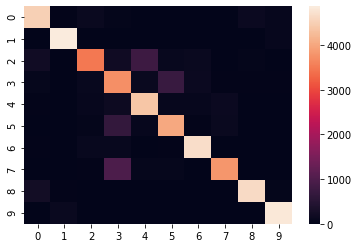

In [ ]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns 



sns.heatmap(confusion_matrix(df['gt'].values,df['mapped_preds'].values))




In [ ]:
!python eval.py  --visualize_prototypes --config_exp configs/selflabel/selflabel_cifar10.yml --model ./cifar-10/selflabel/model.pth.tar  --save_dir ./cifar-10/images

Read config file configs/selflabel/selflabel_cifar10.yml ...
{'setup': 'selflabel', 'use_ema': False, 'confidence_threshold': 0.99, 'criterion': 'confidence-cross-entropy', 'criterion_kwargs': {'apply_class_balancing': True}, 'backbone': 'resnet18', 'num_heads': 1, 'train_db_name': 'cifar-10', 'val_db_name': 'cifar-10', 'num_classes': 10, 'augmentation_strategy': 'ours', 'augmentation_kwargs': {'crop_size': 32, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}, 'num_strong_augs': 4, 'cutout_kwargs': {'n_holes': 1, 'length': 16, 'random': True}}, 'transformation_kwargs': {'crop_size': 32, 'normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}, 'epochs': 200, 'optimizer': 'adam', 'optimizer_kwargs': {'lr': 0.0001, 'weight_decay': 0.0001}, 'batch_size': 512, 'num_workers': 8, 'scheduler': 'constant'}
Get validation dataset ...
Files already downloaded and verified
Number of samples: 10000
Get model ...
ClusteringModel(
  (backbone): 

In [ ]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt

path = './cifar-10/images'

img_paths = os.listdir(path)

size = len(img_paths)

img_arr = np.zeros((size,32,32,3))

print(img_arr.shape)

for i,file_name in enumerate(os.listdir('./cifar-10/images')):

    print('path : ', path + "/" + file_name)

    img_arr[i] = cv2.imread(path + "/" + file_name)


(10, 32, 32, 3)
path :  ./cifar-10/images/4875.jpg
path :  ./cifar-10/images/6747.jpg
path :  ./cifar-10/images/838.jpg
path :  ./cifar-10/images/9835.jpg
path :  ./cifar-10/images/9582.jpg
path :  ./cifar-10/images/2208.jpg
path :  ./cifar-10/images/3737.jpg
path :  ./cifar-10/images/1789.jpg
path :  ./cifar-10/images/9049.jpg
path :  ./cifar-10/images/5606.jpg


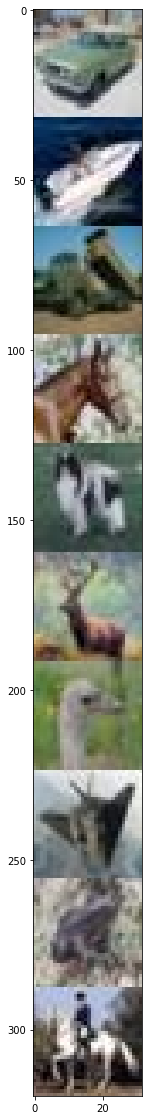

In [ ]:
cv2.imwrite("img.jpg",img_arr.reshape(-1,32,3))

img = cv2.cvtColor(cv2.imread("img.jpg"),cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,20))
plt.imshow(img)